### Time Plot

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import pickle

# Get the file path from environment variable
file_path_env = '/fast/AG_Ohler/ekarimi/projects/FACS_Sampling/data'


REFERENCES = [5, 10, 20, 25, 30]
METHODS = ['cubic', 'hopper', 'atomic',]
methods = ['cubic', 'hopper']
SIZES = [50000, 100000, 200000, 300000]
REPS = [i for i in range(5)]
label_key = 'celltype'


directory = "mcc/benchmark"
PATH = os.path.join(file_path_env, directory)

In [2]:
ref = 1
method = 'cubic'
size = 50000
rep = 0
# REFERENCES = [1, 5]
# methods = ['random', 'cubic', 'atomic', 'hopper']


In [3]:
reference_adatas = {}
for ref in REFERENCES:
    address = os.path.join(PATH, f"{ref}/adata.h5ad")
    adata = sc.read_h5ad(address)
    adata.obs[label_key] = adata.obs[label_key].astype('category')
    adata.var.index = adata.var.index.astype('object')
    reference_adatas[ref] = adata

In [4]:
def prepare_times_ref_fixed():
    times = {}
    for ref in REFERENCES:
        time_list_per_size_per_method = []
        for size in SIZES:
            
            time_list_per_method = []
            for method in METHODS:
                time = 0
                for rep in REPS:
                    if method == 'atomic':
                        if os.path.isfile(os.path.join(PATH, f"{ref}/atomic/{size}/{rep}/runtimes.csv")):
                            atomic_address = os.path.join(PATH, f"{ref}/atomic/{size}/{rep}/runtimes.csv")
                            runtime = pd.read_csv(atomic_address)['runtime'][0]
                        else:
                            continue
                    else:
                        samples_address = os.path.join(PATH, f"{ref}/{method}/{size}/{rep}/results.pkl")
                        with open(samples_address, 'rb') as handle:
                             samples= pickle.load(handle)
                        runtime = samples[1]
                        
                    time += runtime
                time/=len(REPS)
                time_list_per_method.append(time)

            time_list_per_size_per_method.append(time_list_per_method)
            
        time_list_per_size_per_method = np.array(time_list_per_size_per_method).T
        times[ref] = time_list_per_size_per_method
    return times

In [5]:
times = prepare_times_ref_fixed()

### Plot time

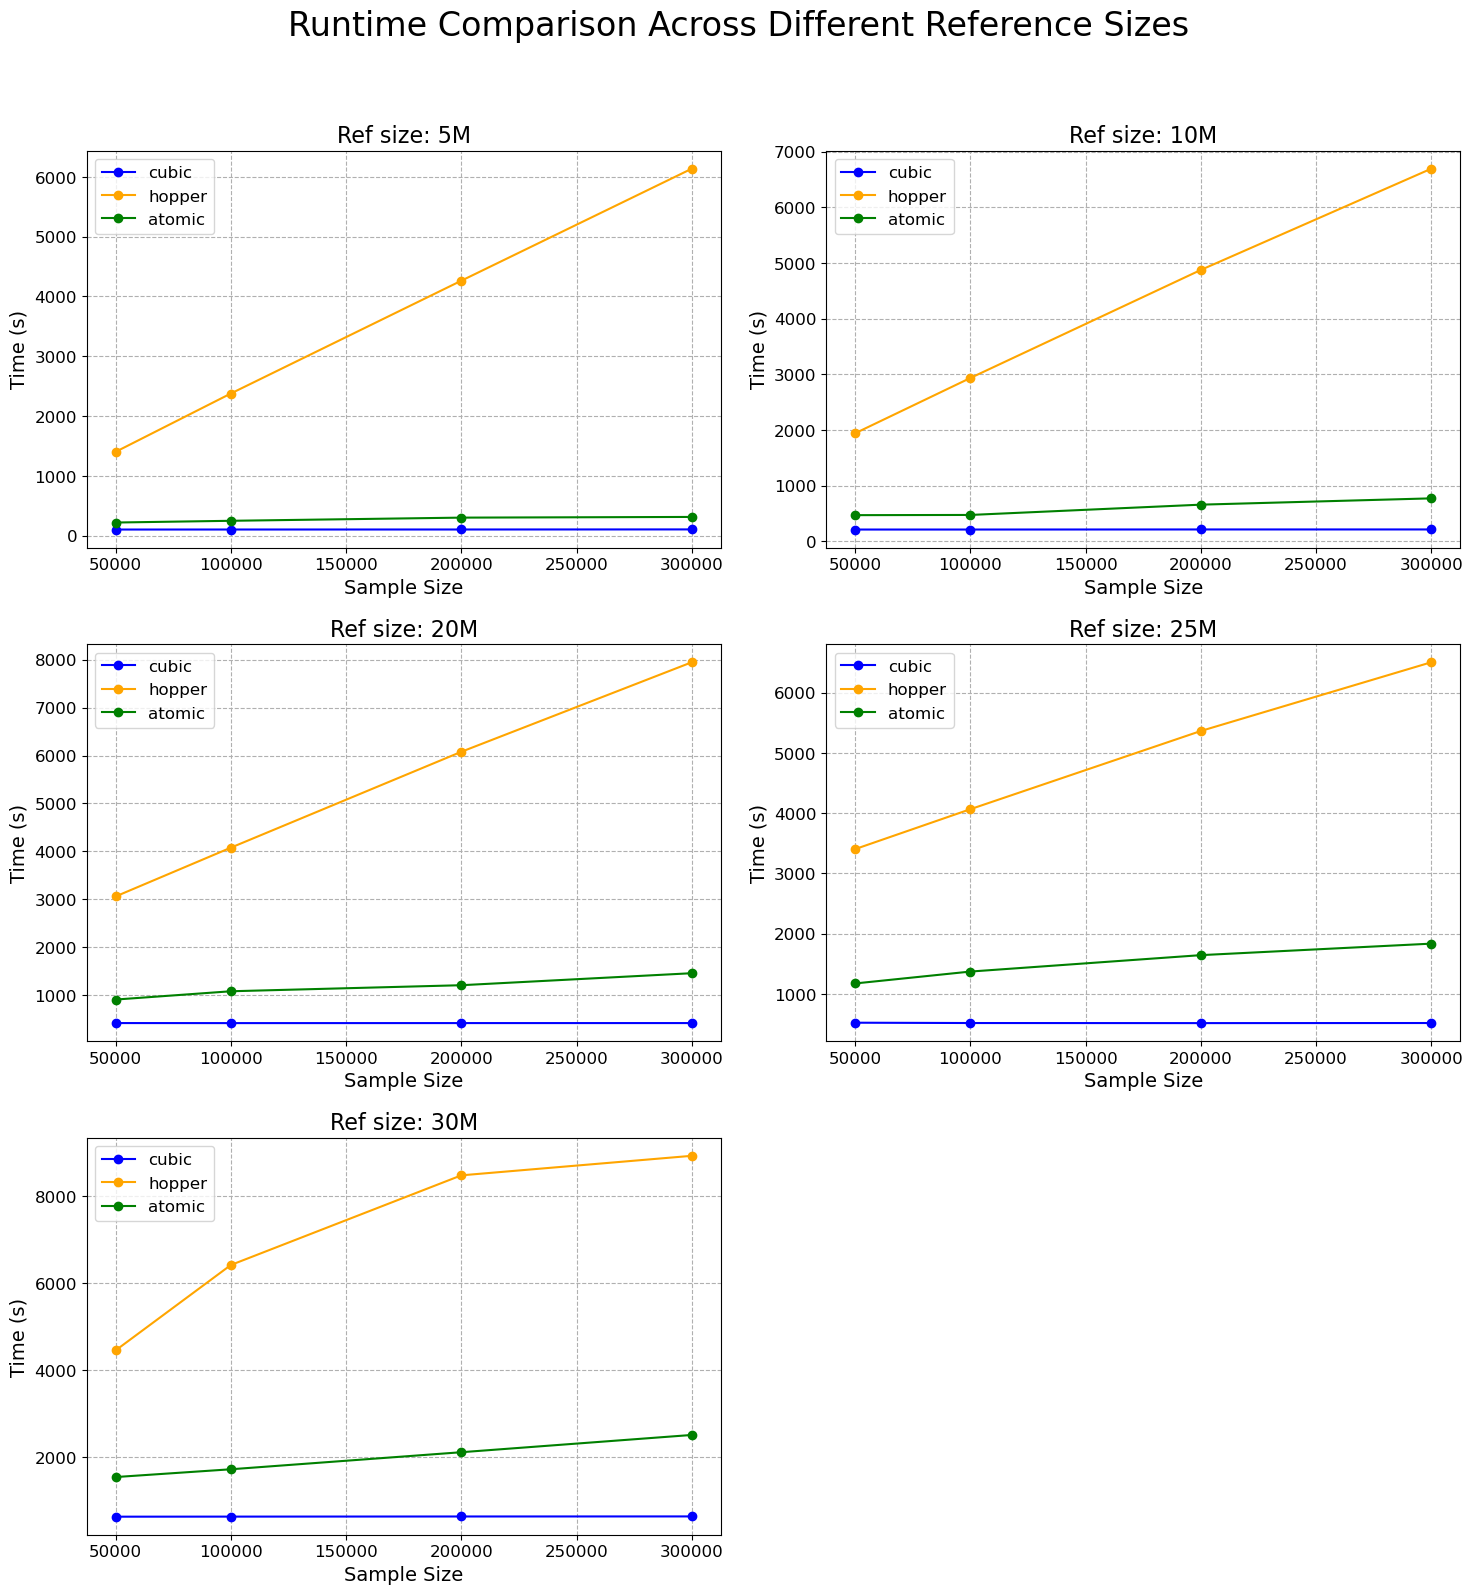

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'axes.titlesize': 16, 'legend.fontsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12})


# Assuming 'a' is your dataset container with 7 datasets, and 'methods_list' is defined
# a = {...}
# methods_list = [...]

# Fixed X-axis values
x_values = np.array(SIZES)
# x_values = np.array([1000, 10000, 20000, 50000, 100000])


# Define the number of rows and columns for the subplot grid, accommodating 7 plots
n_rows = 4  # Adjust the number of rows to fit 7 plots
n_cols = 2

# Colors for each method
# colors = ['purple', 'blue', 'green', 'red', 'orange']
# colors = ['blue', 'green', 'red', 'orange']
colors = ['blue', 'orange', 'green']

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over your dataset container 'a' which has the datasets for each 'batch_id'
for i, ref in enumerate(times.keys()):
    y_streams = times[ref]#[:,:5]
    ax = axes[i]  # Select the subplot
    
    # Plotting each stream for the current subplot
    for j, y_stream in enumerate(y_streams):
        ax.plot(x_values, y_stream, '-o', color=colors[j % len(colors)], label=METHODS[j])

    # Customizations for the subplot
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Time (s)')
    ax.set_title(f'Ref size: {ref}M')
    # ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.grid(True, which="both", ls="--")
    ax.legend()

# Hide any unused subplots if the number of subplots exceeds the datasets
for i in range(len(times), n_rows * n_cols):
    fig.delaxes(axes[i])

    
fig.suptitle('Runtime Comparison Across Different Reference Sizes', size=24, y=1.02)

# Adjust layout to prevent overlapping
fig.tight_layout()

# Save the entire figure with all subplots to a file
plt.savefig('time_comparison_per_ref_size.png', format='png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()



In [7]:
def prepare_times_sample_size_fixed():
    times = {}
    for size in SIZES:
        time_list_per_ref_per_method = []
        for ref in REFERENCES:
            time_list_per_method = []
            for method in METHODS:
                time = 0
                for rep in REPS:
                    if method == 'atomic':
                        if os.path.isfile(os.path.join(PATH, f"{ref}/atomic/{size}/{rep}/runtimes.csv")):
                            atomic_address = os.path.join(PATH, f"{ref}/atomic/{size}/{rep}/runtimes.csv")
                            runtime = pd.read_csv(atomic_address)['runtime'][0]
                        else:
                            continue
                    else:
                        samples_address = os.path.join(PATH, f"{ref}/{method}/{size}/{rep}/results.pkl")
                        with open(samples_address, 'rb') as handle:
                             samples= pickle.load(handle)
                        runtime = samples[1]
                        
                    time += runtime
                time/=len(REPS)
                time_list_per_method.append(time)

            time_list_per_ref_per_method.append(time_list_per_method)
            
        time_list_per_ref_per_method = np.array(time_list_per_ref_per_method).T
        times[size] = time_list_per_ref_per_method
    return times

In [8]:
times = prepare_times_sample_size_fixed()

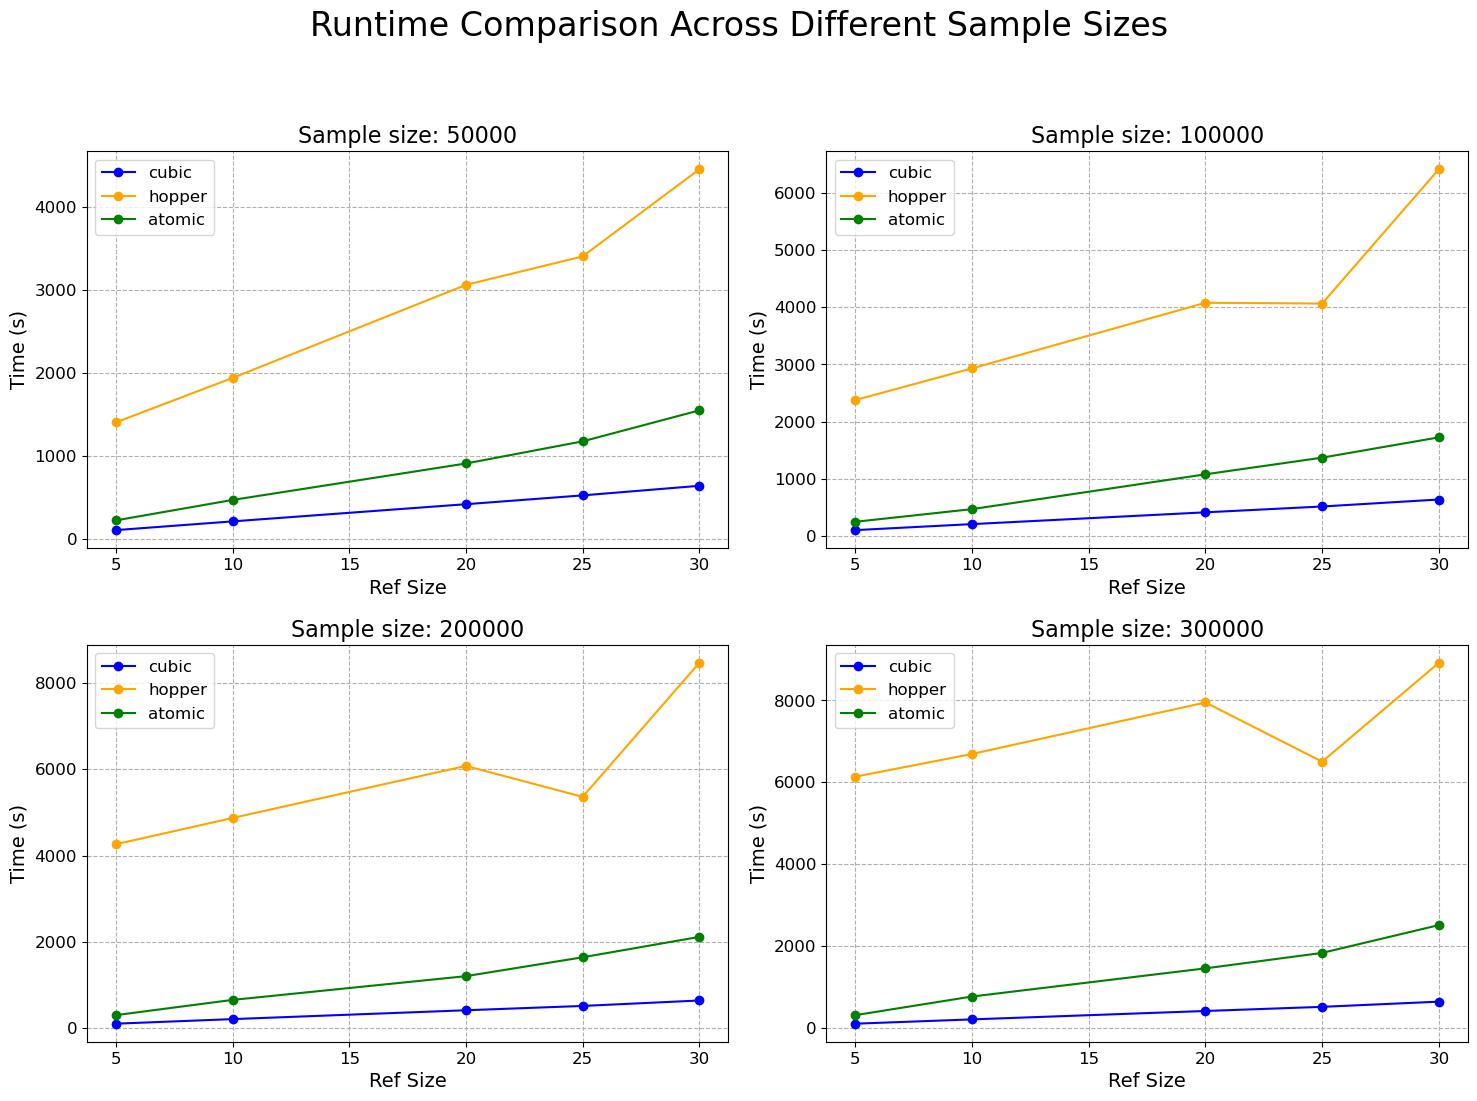

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'axes.titlesize': 16, 'legend.fontsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12})


# Assuming 'a' is your dataset container with 7 datasets, and 'methods_list' is defined
# a = {...}
# methods_list = [...]

# Fixed X-axis values
x_values = np.array(REFERENCES)
# x_values = np.array([1000, 10000, 20000, 50000, 100000])


# Define the number of rows and columns for the subplot grid, accommodating 7 plots
n_rows = 4  # Adjust the number of rows to fit 7 plots
n_cols = 2

# Colors for each method
# colors = ['purple', 'blue', 'green', 'red', 'orange']
# colors = ['blue', 'green', 'red', 'orange']
colors = ['blue', 'orange', 'green']

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over your dataset container 'a' which has the datasets for each 'batch_id'
for i, size in enumerate(times.keys()):
    y_streams = times[size]#[:,:5]
    ax = axes[i]  # Select the subplot
    
    # Plotting each stream for the current subplot
    for j, y_stream in enumerate(y_streams):
        ax.plot(x_values, y_stream, '-o', color=colors[j % len(colors)], label=METHODS[j])

    # Customizations for the subplot
    ax.set_xlabel('Ref Size')
    ax.set_ylabel('Time (s)')
    ax.set_title(f'Sample size: {size}')
    # ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.grid(True, which="both", ls="--")
    ax.legend()

# Hide any unused subplots if the number of subplots exceeds the datasets
for i in range(len(times), n_rows * n_cols):
    fig.delaxes(axes[i])

fig.suptitle('Runtime Comparison Across Different Sample Sizes', size=24, y=1.02)

# Adjust layout to prevent overlapping
fig.tight_layout()

# Save the entire figure with all subplots to a file
plt.savefig('time_comparison_per_sample_size.png', format='png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()

